- **Problem** \
Bagaimana menentukan harga jual mobil bekas yang pengguna miliki
- **Solusi** \
Membuat machine learning yang mampu memprediksi harga jual mobil bekas

# Library

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="Paired")

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import normaltest
from scipy.stats import kruskal
import category_encoders as ce
from sklearn.compose import ColumnTransformer
import plotly.express as px


# statistic
from scipy.stats import chi2_contingency

# preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

# model regression
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# model selection & hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# metric classification
from sklearn.metrics import recall_score, precision_score, classification_report, f1_score

# Data

In [2]:
car_models = ['audi', 'bmw', 'cclass', 'focus', 'ford', 'hyundi', 'merc', 'skoda', 'toyota', 'vauxhall', 'vw']
df = pd.DataFrame()

for i in car_models:
    carmodel_df = pd.read_csv('dataset/'+i+'.csv')
    if i == 'hyundi':
        carmodel_df = carmodel_df.rename(columns={'tax(£)': 'tax'})

    carmodel_df['brand']=i
    df = pd.concat([df, carmodel_df])
    

In [3]:
# karena dataframe ini merupakan penggabungan dari banyak dataframe
# maka perlu dilakukan reset_index untuk menghilangkan index yang duplikat
df = df.reset_index()

In [4]:
# drop index lama
df = df.drop(columns='index')
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi


- model = tipe mobil.
- year = tahun produksi mobil.
- price = nilai harga jual mobil.
- transmission = tipe transmisi dari mobil.
- mileage = total jarak yang telah ditempuh oleh mobil.
- fuelType = jenis bahan bakar yang digunakan pada mobil.
- tax = nilai pajak mobil.
- mpg = miles per gallon; total jarak tempuh mobil berdasarkan total konsumsi bahan bakar yg digunakan. semakin besar nilai mpg berarti konsumsi bahan bakar yg digunakan akan semakin sedikit (semakin irit).
- engine size = engine capacity atau engine displacement (kapasitas mesin); volume total silinder mesin. secara umum, semakin besar nilai kapasitas mesin akan meningkatkan kebutuhan konsumsi bahan bakar (kendaraan akan semakin boros).

# EDA

## Deskripsi Statistik

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           99187 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
 9   brand         108540 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 8.3+ MB


In [6]:
df.describe(include=object)

,model,transmission,fuelType,brand
count,108540,108540,108540,108540
unique,195,4,5,11
top,Focus,Manual,Petrol,ford
freq,10042,61308,59875,17965


In [7]:
df.isna().sum() / df.shape[0] * 100

model           0.0000
year            0.0000
price           0.0000
transmission    0.0000
mileage         0.0000
fuelType        0.0000
tax             8.6171
mpg             8.6171
engineSize      0.0000
brand           0.0000
dtype: float64

> terdapat missing value pada fitur tax & mpg

In [8]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,108540.000000,108540.000000,108540.000000,99187.000000,99187.000000,108540.000000
mean,2017.098028,16890.124046,23025.928469,120.299838,55.166825,1.661644
std,2.130057,9756.266820,21176.423684,63.150926,16.138522,0.557058
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10229.500000,7491.750000,125.000000,47.100000,1.200000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000,1.600000
75%,2019.000000,20940.000000,32236.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


> dari data diatas, dapat kita lihat bahwa engineSize memiliki nilai minimum 0, dimana hal tersebut tidak mungkin karena tidak ada kendaraan dengan engineSize = 0

## Handling Imbalance Data

### Imbalance Data in fuelType

In [9]:
df.groupby('fuelType').size() / df.shape[0] * 100

fuelType
Diesel      41.622443
Electric     0.005528
Hybrid       2.974940
Other        0.233094
Petrol      55.163995
dtype: float64

> - Berdasarkan data diatas, mobil dengan bahan bakar Electric, Hybrid & Other berkisar sekitar 3.213% dari keseluruhan data
> - Karena data tersebut terlalu sedikit dan tidak signifikan maka data tersebut akan di drop

In [10]:
df.drop(df[(df['fuelType'] == 'Electric') | (df['fuelType'] == 'Hybrid') | (df['fuelType'] == 'Other')].index, inplace= True)


In [11]:
df.groupby('fuelType').size() / df.shape[0] * 100

fuelType
Diesel    43.004417
Petrol    56.995583
dtype: float64

### Imbalance Data in Transmission

In [12]:
df.groupby('transmission').size() / df.shape[0] * 100

transmission
Automatic    18.368998
Manual       58.303507
Other         0.006663
Semi-Auto    23.320832
dtype: float64

> - Berdasarkan data diatas, mobil dengan tipe transmisi other berkisar sekitar 0.005% dari keseluruhan data
> - Karena data tersebut terlalu sedikit dan tidak signifikan maka data tersebut akan di drop

In [13]:
df.drop(df[(df['transmission'] == 'Other')].index, inplace= True)


In [14]:
df.groupby('fuelType').size() / df.shape[0] * 100

fuelType
Diesel    43.004427
Petrol    56.995573
dtype: float64

## Handling Anomali Data

### Data 'year' = 2060

In [15]:
df[df['year'] == 2060]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
48528,Fiesta,2060,6495,Automatic,54807,Petrol,205.0,42.8,1.4,ford


In [16]:
df.drop(df[df['year'] == 2060].index, inplace = True)

In [17]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,105044.000000,105044.000000,105044.000000,95849.000000,95849.000000,105044.000000
mean,2017.096417,16815.920471,22985.290097,121.892717,53.985638,1.658356
std,2.137326,9808.896290,21187.595856,62.370738,10.941017,0.561822
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10000.000000,7450.000000,125.000000,46.300000,1.200000
50%,2017.000000,14499.000000,17171.000000,145.000000,54.300000,1.500000
75%,2019.000000,20750.000000,32191.000000,145.000000,61.400000,2.000000
max,2020.000000,159999.000000,323000.000000,580.000000,166.200000,6.600000


### Data 'engineSize' = 0

In [18]:
df[df['engineSize'] == 0.0].head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
7505,Q5,2019,44790,Automatic,5886,Petrol,135.0,117.7,0.0,audi
7506,Q3,2019,32788,Automatic,1500,Diesel,145.0,47.1,0.0,audi
7516,Q3,2020,29944,Manual,1500,Petrol,145.0,40.9,0.0,audi
7517,Q3,2020,33333,Automatic,1500,Diesel,145.0,47.1,0.0,audi
7518,Q3,2020,29944,Automatic,1500,Petrol,145.0,32.5,0.0,audi


In [19]:
totalZeroEngine = df[df['engineSize'] == 0.0]['engineSize'].count()
zeroEnginePersentage = totalZeroEngine / df.shape[0] * 100
print('karena hanya terdapat sebanyak', totalZeroEngine, 'data atau sebesar', round(zeroEnginePersentage, 3), '% dari keseluruhan data, maka data dengan engineSize = 0.0 akan didrop')

karena hanya terdapat sebanyak 245 data atau sebesar 0.233 % dari keseluruhan data, maka data dengan engineSize = 0.0 akan didrop


In [20]:
df = df.drop(df[df['engineSize'] == 0.0].index, axis = 0)

## Missing Value

### Handling Missing Value in Tax

* input Missing Value in Tax menggunakan nilai rata-rata berdasarkan fuelType
* referensi:
    1. https://www.gov.uk/calculate-tax-rates-for-new-cars
    2. https://www.gov.uk/vehicle-tax-rate-tables

In [21]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi


In [22]:
df['tax']=df['tax'].fillna(df.groupby(['fuelType'])['tax'].transform('mean'))

### Handling Missing Value in MPG

* input Missing Value in MPG menggunakan nilai rata-rata berdasarkan transmission, fuelType, engineSize

In [23]:
df['mpg']=df['mpg'].fillna(df.groupby(['transmission','fuelType','engineSize'])['mpg'].transform('mean'))

In [24]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             2
engineSize      0
brand           0
dtype: int64

>dikarenakan masih ada data yg bernilai NaN tetapi jumlah data tersebut tidak akan terlalu mempengaruhi keseluruhan data makan data tersebut akan di drop.

In [25]:
df.dropna(inplace=True)

In [26]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
brand           0
dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104797 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         104797 non-null  object 
 1   year          104797 non-null  int64  
 2   price         104797 non-null  int64  
 3   transmission  104797 non-null  object 
 4   mileage       104797 non-null  int64  
 5   fuelType      104797 non-null  object 
 6   tax           104797 non-null  float64
 7   mpg           104797 non-null  float64
 8   engineSize    104797 non-null  float64
 9   brand         104797 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 8.8+ MB


## Feature Engineering

### fitur Age

In [28]:
df['age']=2020-df['year']
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi,3
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi,4
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi,4
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi,3
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi,1


## Data Visualization (in general)

### Percentage of Transmission Type

In [29]:
df_tr=df.groupby('transmission').count()['model'].reset_index()
df_tr= df_tr.rename(columns={'model': 'jumlah'})
df_tr

,transmission,jumlah
0,Automatic,19218
1,Manual,61080
2,Semi-Auto,24499


In [30]:
# fig = px.pie(df_tr,
#             names='transmission',
#             values='jumlah',
#             title='Percentage of Transmission Type',
#             color_discrete_sequence=px.colors.sequential.amp
#             )
# fig.show()

### Percentage of fuelType

In [31]:
df_ft=df.groupby('fuelType').count()['model'].reset_index()
df_ft= df_ft.rename(columns={'model': 'jumlah'})
df_ft

,fuelType,jumlah
0,Diesel,45101
1,Petrol,59696


In [32]:
# fig = px.pie(df_ft,
#             names='fuelType',
#             values='jumlah',
#             title='Percentage of fuelType',
#             color_discrete_sequence=px.colors.sequential.Peach
#             )
# fig.show()

### Tree Map

In [33]:
df_treemap = df.groupby(['year','transmission','fuelType']).agg({'model':len,'price':np.mean}).rename(columns={'name':'total'}).reset_index()
df_treemap.head()

,year,transmission,fuelType,model,price
0,1970,Manual,Petrol,1,10495.0
1,1991,Automatic,Petrol,1,4450.0
2,1996,Automatic,Petrol,1,5995.0
3,1996,Manual,Petrol,1,3000.0
4,1997,Automatic,Petrol,2,7322.5


In [34]:
# fig = px.treemap(df_treemap,
#                  path=['year','transmission','fuelType'], 
#                  values = 'price', 
#                  color = 'price',
#                  color_continuous_scale='RdBu',
#                  color_continuous_midpoint=np.average(df['price'], weights=df['price']),
#                  width=1000,
#                  height=600,
#                  title = "Nilai Rata-Rata price berdasarkan year, transmission, dan fuelType:"
#                  )
# fig.show()

### Time Series

ref gambar nanti time series:
    
    https://www.moneysupermarket.com/car-insurance/petrol-vs-diesel/?__cf_chl_jschl_tk__=pmd_gyDQZeymIJ8ilTuI76rL9Flxin2tASMb5MaXlCu5JIE-1630055221-0-gqNtZGzNAjujcnBszQi9

In [35]:
yearXfuel = pd.crosstab(df['year'], df['fuelType']).reset_index()
yearXfuel.head()

fuelType,year,Diesel,Petrol
0,1970,0,1
1,1991,0,1
2,1996,0,2
3,1997,0,4
4,1998,1,8


In [36]:
# plt.figure(figsize=(15,5))
# plt.scatter(yearXfuel['year'], yearXfuel['Diesel'])
# plt.plot(yearXfuel['year'], yearXfuel['Diesel'])

# plt.scatter(yearXfuel['year'], yearXfuel['Petrol'])
# plt.plot(yearXfuel['year'], yearXfuel['Petrol'])

# plt.legend(labels=['Diesel', 'Petrol'])
# plt.show()

### Tren Penjualan Mobil Tiap Tahunnya

In [37]:
# plt.figure(figsize=(15,5))
# sns.countplot(data=df, x='year')
# plt.show()

> terdapat tren peningkatan penjualan mobil tiap tahunnya

### Brand & Price Trend by Year

In [38]:
# plt.figure(figsize=(15,10))
# sns.lineplot(data=df, x="age", y="price", hue="brand")
# plt.show()

> - terlihat tren penurunan harga mobil ketika umur mobil semakin tua dihampir semua merk mobil
> - berdasarkan graph diatas juga dapat kita lihat terdapat 4 brand yang memiliki rata-rata price lebih tinggi dibanding brand lainnya, yaitu audi, bmw, merc, cclass dikarenakan mereka termasuk brand mobil mewah
> - terlihat tren peningkatan harga untuk mobil dengan brand vauxhall  yang berumur diatas 20 tahun
> - terlihat anomali peningkatan harga yang signifikan untuk brand toyota berumur diatas 20 tahun

In [39]:
# anomali data dibrand toyota
df[(df['brand'] == 'toyota') & (df['age'] >= 20)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
75463,Yaris,1999,1995,Automatic,89000,Petrol,160.0,42.9,1.3,toyota,21
75621,Yaris,2000,2695,Automatic,21000,Petrol,160.0,42.9,1.3,toyota,20
79707,Land Cruiser,1998,19990,Manual,100000,Diesel,265.0,23.9,4.2,toyota,22


> dari tabel diatas, dapat kita ketahui anomali pada tren harga toyota dikarenakan oleh 1 data yaitu "Land Cruiser" tahun 1998 yang memiliki harga £19990 

In [40]:
df[(df['brand'] == 'vauxhall') & (df['age'] >= 20)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
85608,Astra,1997,950,Manual,89233,Petrol,265.0,35.8,1.6,vauxhall,23
90588,Zafira,1970,10495,Manual,37357,Petrol,200.0,42.2,1.4,vauxhall,50


> dari tabel diatas, dapat kita ketahui tren peningkatan harga dibrand vauxhall dikarenakan oleh 1 data yaitu mobil model "Zahira" keluaran tahun 1970 yang memiliki harga £10495

## Summary Statistic
(terhadap variabel-variabel yg berpotensi memengaruhi Nilai _price_)

### Cek Normalisasi Data

In [41]:
num_features=list(df.dtypes[df.dtypes!=object].index)
num_features.remove('year')
num_features

['price', 'mileage', 'tax', 'mpg', 'engineSize', 'age']

In [42]:
factors = df[num_features]

In [43]:
for i in factors:
    stats,pval=normaltest(factors[i])
    print('Nilai p-Value =',pval)
    if pval <= 0.05:
        print(f'Fitur {i} distribusi tidak normal\n')
    else:
        print(f'Fitur {i} distribusi normal\n')

Nilai p-Value = 0.0
Fitur price distribusi tidak normal

Nilai p-Value = 0.0
Fitur mileage distribusi tidak normal

Nilai p-Value = 0.0
Fitur tax distribusi tidak normal

Nilai p-Value = 1.9478672435541904e-27
Fitur mpg distribusi tidak normal

Nilai p-Value = 0.0
Fitur engineSize distribusi tidak normal

Nilai p-Value = 0.0
Fitur age distribusi tidak normal



### Cek Korelasi Data

In [44]:
num_features=list(df.dtypes[df.dtypes!=object].index)
num_features.remove('year')
num_features

['price', 'mileage', 'tax', 'mpg', 'engineSize', 'age']

In [45]:
corr_matrix=df[num_features].corr(method='spearman')
corr_matrix

,price,mileage,tax,mpg,engineSize,age
price,1.000000,-0.526539,0.316000,-0.419202,0.574906,-0.608507
mileage,-0.526539,1.000000,-0.266530,0.337679,0.102839,0.815230
tax,0.316000,-0.266530,1.000000,-0.548082,0.153360,-0.327277
mpg,-0.419202,0.337679,-0.548082,1.000000,-0.227803,0.321426
engineSize,0.574906,0.102839,0.153360,-0.227803,1.000000,0.041449
age,-0.608507,0.815230,-0.327277,0.321426,0.041449,1.000000


* 0-0.3 = weak correlation
* 0.3-0.7 = moderate correlation
* 0.7-1 = strong correlation

* Positive (+) = one variable increases as the other increases the correlation
* Negative (-) = when one decreases as the other increases it
* Complete absence of correlation is represented by 0

Ref: materi Association

In [46]:
# # plt.figure(figsize=(12,8))

# sns.set_theme(style="white")

# mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
# cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

# sns.heatmap(corr_matrix,
#             mask=mask,
#             cmap=cmap,
#             vmax=1,
#             vmin=-1,
#             linewidths=.2
#            )

# plt.yticks(rotation=0)
# plt.xticks(rotation=60)
# plt.show()

### Cek Distribusi Data

In [47]:
kolom=df.columns

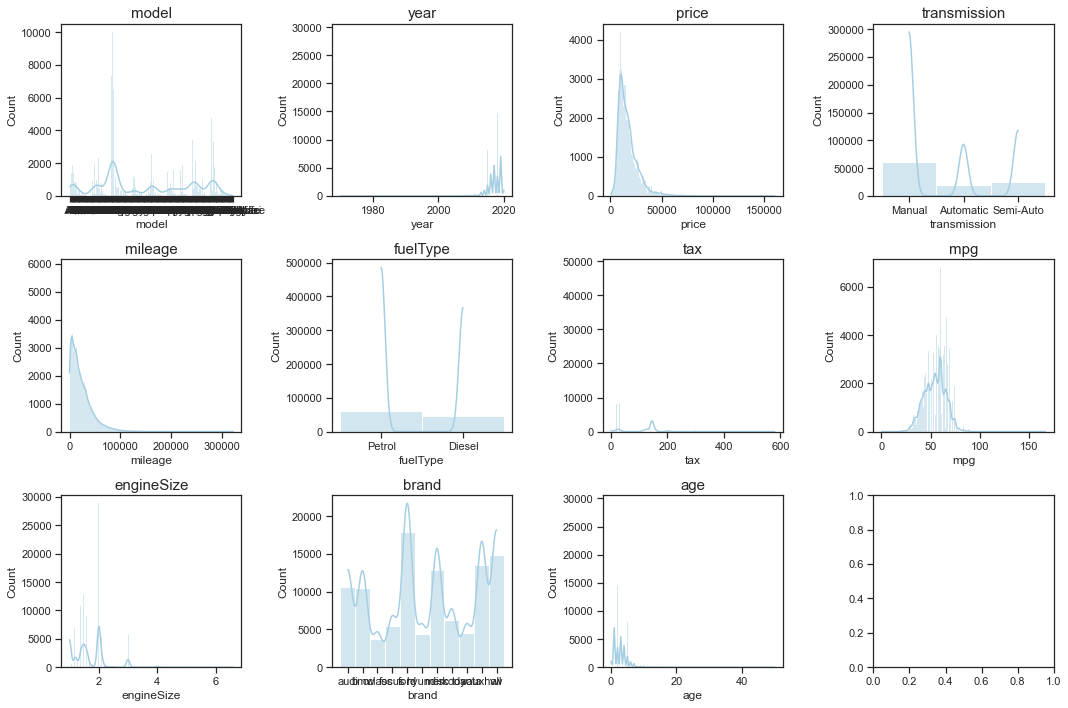

In [114]:
figure, axis = plt.subplots(3,4,figsize=(15,10))

k=0

for i in range(0,3):
    for j in range (0,4):
        if(k == 11):
            break;
        axis[i,j].set_title(kolom[k], size=15)
        sns.histplot(ax=axis[i,j], data = df, x=kolom[k], kde=True)
        k+=1

# auto padding subplot
plt.tight_layout()
plt.show()

In [116]:
df[df['price'] > 60000]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
198,Q7,2020,62985,Semi-Auto,10,Diesel,145.0,33.2,3.0,audi,0
299,Q8,2018,63985,Semi-Auto,8450,Diesel,145.0,32.8,3.0,audi,2
316,Q7,2020,82995,Semi-Auto,826,Diesel,145.0,29.4,4.0,audi,0
632,RS4,2020,69995,Semi-Auto,2200,Petrol,145.0,28.8,2.9,audi,0
640,Q7,2018,60995,Automatic,3893,Diesel,145.0,39.2,4.0,audi,2
...,...,...,...,...,...,...,...,...,...,...,...
66665,C Class,2020,68995,Automatic,2000,Petrol,145.0,28.0,4.0,merc,0
66687,A Class,2017,109495,Automatic,1755,Petrol,145.0,24.8,4.0,merc,3
71739,Karoq,2019,91874,Automatic,3764,Petrol,145.0,40.9,1.5,skoda,1
108500,California,2020,61995,Semi-Auto,1000,Diesel,260.0,32.1,2.0,vw,0


* berdasarkan histplot, sebaran data feature cenderung *right-skew*
* dapat disimpulkan secara umum persebaran data memiliki distribusi tidak normal.

In [49]:
# figure, axis = plt.subplots(2,3,figsize=(15,10))

# k=0

# for i in range(0,2):
#     for j in range (0,3):
#         axis[i,j].set_title(num_features[k], size=15)
#         sns.boxplot(ax=axis[i,j], data = df, x=num_features[k])
#         k+=1

# # auto padding subplot
# plt.tight_layout()
# plt.show()

* berdasarkan boxplot, sebaran data feature memiliki banyak outlier di sebelah kanan.
* dapat disimpulkan persebaran data memiliki distribusi tidak normal.

### Uji Analisa

#### Uji 1 : _price_ vs _mileage_

**Korelasi :**

In [50]:
round(df['price'].corr(df['mileage'],method='spearman'),6)

-0.526539

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding terbalik** dengan fitur _mileage_, dimana nilai korelasinya adalah 0.526539 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _mileage_** dari mobil akan menyebabkan **nilai _price_ semakin rendah**.

**Visualisasi :**

In [51]:
# plt.figure(figsize=(15,10))
# plt.subplot(2,1,1)
# sns.scatterplot(data=df, x='mileage', y='price', hue='fuelType')
# plt.title('price vs mileage', size=15)
# plt.show()

# plt.figure(figsize=(15,10))
# plt.subplot(2,1,2)
# sns.scatterplot(data=df, x='mileage', y='price', hue='brand')
# plt.title('price vs mileage', size=15)
# plt.show()

**Kesimpulan Uji 1 :**

1. Total jarak yg telah ditempuh memiliki pengaruh terhadap penentuan harga jual mobil, dimana semakin tinggi total jarak tempuh yg telah dilakukan mobil maka nilai jual mobil akan semakin rendah.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil yg memiliki harga jual tinggi adalah mobil dengan nilai jarak tempuh yg rendah dengan tipe bahan bakar bakar Petrol.
    * mobil yg memiliki harga jual rendah adalah mobil dengan jarak tempuh yg tinggi dengan tipe bahan bakar Diesel.

#### Uji 2 : _price_ vs _tax_

**Korelasi :**

In [52]:
round(df['price'].corr(df['tax'],method='spearman'),6)

0.316

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding Lurus** dengan fitur _tax_, dimana nilai korelasinya adalah 0.316 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _tax_** dari mobil akan menyebabkan **nilai _price_ semakin tinggi**.

**Visualisasi :**

In [53]:
# plt.figure(figsize=(15,10))
# plt.subplot(2,1,1)
# sns.scatterplot(data=df, x='tax', y='price', hue='fuelType')
# plt.title('price vs tax', size=15)
# plt.show()

# plt.figure(figsize=(15,10))
# plt.subplot(2,1,2)
# sns.scatterplot(data=df, x='tax', y='price', hue='brand')
# plt.title('price vs tax', size=15)
# plt.show()

**Kesimpulan Uji 2 :**

1. Nilai pajak mobil memiliki pengaruh kecil terhadap penentuan harga jual mobil.
2. Pada data ini, secara umum digambarkan bahwa:
    * Mobil dengan jenis bahan bakar _Diesel_ secara umum memiliki rata-rata range nilai _tax_ serta nilai _price_ yg relatif lebih rendah dibandingkan mobil dengan jenis bahan bakar petrol. 
    * Mobil brand mewah  memiliki harga yang tinggi tapi pajak relatif rendah, hal ini kemungkinan dipengaruhi oleh nama brand tersebut yang mampu memberikan nilai jual lebih tinggi dibanding brand lainnya

#### Uji 3 : _price_ vs _mpg_

**Korelasi :**

In [54]:
round(df['price'].corr(df['mpg'],method='spearman'),6)

-0.419202

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding terbalik** dengan fitur _mpg_, dimana nilai korelasinya adalah 0.419202 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _mpg_** dari mobil akan menyebabkan **nilai _price_ semakin rendah**.

**Visualisasi :**

In [55]:
# plt.figure(figsize=(15,10))
# plt.subplot(2,1,1)
# sns.scatterplot(data=df, x='mpg', y='price', hue='fuelType')
# plt.title('price vs mileage', size=15)
# plt.show()

# plt.figure(figsize=(15,12))
# plt.subplot(2,1,2)
# sns.scatterplot(data=df, x='mpg', y='price', hue='brand')
# plt.title('price vs mpg', size=15)
# plt.show()

**Kesimpulan Uji 3 :**

1. Total jarak tempuh mobil berdasarkan total konsumsi bahan bakar yg digunakan memiliki pengaruh kecil terhadap penentuan harga jual mobil.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil dengan tipe bahan bakar bakar Petrol memiliki sebaran nilai mpg yg relatif rendah tetapi memiliki range harga jual yg paling variatif; hal ini dapat disebabkan karena mobil dengan brand mewah memiliki price yang relatif tinggi
    * mobil dengan tipe bahan bakar bakar Diesel memiliki sebaran nilai mpg dan price menengah keatas.


#### Uji 4 : _price_ vs _engineSize_

**Korelasi :**

In [56]:
round(df['price'].corr(df['engineSize'],method='spearman'),6)

0.574906

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding Lurus** dengan fitur _engineSize_, dimana nilai korelasinya adalah 0.574906 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _engineSize_** dari mobil akan menyebabkan **nilai _price_ semakin tinggi**.

**Visualisasi :**

In [57]:
# plt.figure(figsize=(15,15))
# plt.subplot(3,1,1)
# graph=sns.barplot(data=df, x='engineSize', y='price', ci=None)
# plt.title('Perbandingan nilai Rata-Rata price berdasarkan engineSize')
# plt.xticks(rotation=45)
# plt.show()

# plt.figure(figsize=(15,10))
# plt.subplot(3,1,2)
# sns.scatterplot(data=df, x='engineSize', y='price', hue='fuelType')
# plt.title('price vs engineSize') 
# plt.show()

# plt.figure(figsize=(15,15))
# plt.subplot(3,1,3)
# sns.scatterplot(data=df, x='engineSize', y='price', hue='brand')
# plt.title('price vs engineSize') 
# plt.show()

**Kesimpulan Uji 4 :**

1. Volume total silinder mesin pengaruh terhadap penentuan harga jual mobil, dimana semakin besar nilai volume total silinder mesin maka nilai jual mobil akan semakin tinggi.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil dengan tipe bahan bakar bakar Petrol memiliki sebaran nilai _engineSize_ dan harga jual yg paling variatif; hal ini dapat disebabkan karena mobil dengan brand mewah memiliki price yang relatif tinggi.
    * mobil dengan tipe bahan bakar bakar Diesel memiliki sebaran nilai _engineSize_ yg relatif menengah tetapi memiliki range harga jual yg relatif rendah hingga tidak terlalu tinggi.

#### Uji 5 : _price_ vs _age_

Hipotesis:

Ho: rata-rata harga mobil di tiap umur bernilai sama

Ha: rata-rata harga mobil di tiap umur setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [58]:
ages=list(df['age'].unique())

In [59]:
stats,pval = kruskal(*[df[df['age'] == i]['price'] for i in ages])

print('Nilai statistic:',stats)
print('Nilai p-value:',pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata harga mobil di tiap umur setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata harga mobil di tiap umur bernilai sama.')

Nilai statistic: 40926.859200730425
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata harga mobil di tiap umur setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Korelasi :**

In [60]:
round(df['price'].corr(df['age'],method='spearman'),6)

-0.608507

**Analisa Korelasi :**

* Fitur _price_ memiliki korelasi **moderate** serta **berbanding Terbalik** dengan fitur _age_, dimana nilai korelasinya adalah 0.608507 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _age_** dari mobil akan menyebabkan **nilai _price_ semakin rendah**.

**Visualisasi :**

In [61]:
# plt.figure(figsize=(15,15))
# plt.subplot(2,1,1)
# sns.barplot(data=df, x='age', y='price', ci=None)
# plt.title('price vs age')
# plt.show()

# plt.figure(figsize=(15,15))
# plt.subplot(2,1,2)
# sns.barplot(data=df, x='year', y='price', ci=None)
# plt.title('price vs year')
# plt.show()

**Kesimpulan Uji 5 :**

1. Umur mobil memiliki pengaruh besar terhadap penentuan harga jual mobil, dimana semakin muda umur mobil maka semakin mahal harga mobilnya.
2. Pada data ini, secara umum digambarkan bahwa:
    * mobil dengan umur 0 tahun  memiliki rata-rata harga jual yg lebih tinggi dibanding mobil yg lebih tua.
    * mobil dengan umur 50 tahun (tahun registrasi 1970) memiliki harga jual yg relatif cukup tinggi jika dibandingkan dengan mobil berumur lainnya, hal ini kemungkinan dikarenakan mobil tersebut merupakan mobil antik / mobil klasik sehingga memiliki nilai historis sebagai variabel perhitungan lain.

#### Uji 6 : _price_ vs _transmission_ 

Hipotesis:

Ho: rata-rata harga mobil tiap tipe transmisi saling bernilai sama 

Ha: rata-rata harga mobil tiap tipe transmisi setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [62]:
transm=list(df['transmission'].unique())

In [63]:
stats,pval = kruskal(*[df[df['transmission'] == i]['price'] for i in transm])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata harga mobil tiap tipe transmisi setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata harga mobil tiap tipe transmisi saling bernilai sama.')

Nilai statistic: 38512.31575954891
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata harga mobil tiap tipe transmisi setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Visualisasi :**

In [64]:
# plt.figure(figsize=(15,10))
# plt.subplot(3,1,1)
# graph=sns.barplot(data=df, x='transmission', y='price', ci=None)
# for p in graph.patches:
#     height = p.get_height()
#     graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
#                 ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
#                 textcoords='offset points')
# plt.ylim(0, 30000)    
# plt.title('Perbandingan nilai Rata-Rata price berdasarkan transmission') 
# plt.show()

# plt.figure(figsize=(15,10))
# plt.subplot(3,1,2)
# sns.scatterplot(data=df, x='transmission', y='price', hue='fuelType')
# plt.title('price vs transmission') 
# plt.show()

# plt.figure(figsize=(15,16))
# plt.subplot(3,1,3)
# sns.scatterplot(data=df, x='transmission', y='price', hue='brand')
# plt.title('price vs transmission') 
# plt.show()

**Kesimpulan Uji 6 :**

1. Jenis transmisi memiliki pengaruh besar terhadap penentuan harga jual mobil, dimana mobil dengan jenis transmisi _Semi-Auto_ memiliki rata-rata harga jual yg lebih tinggi dibanding mobil dengan jenis transmisi lainnya sedangkan mobil dengan jenis transmisi _Manual_ memiliki rata-rata harga jual yg paling rendah dibanding mobil dengan jenis transmisi lainnya.
2. Pada data ini, secara umum digambarkan bahwa sebaran jenis mobil dengan masing-masing jenis bahan bakar terhadap masing-masing tipe transmisi tersebar dengan cukup merata.

#### Uji 7 : _price_ vs _fuelType_

Hipotesis:

Ho: rata-rata harga mobil tiap jenis bahan bakar saling bernilai sama 

Ha: rata-rata harga mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [65]:
fuel=list(df['fuelType'].unique())

In [66]:
stats,pval = kruskal(*[df[df['fuelType'] == i]['price'] for i in fuel])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata harga mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata harga mobil tiap jenis bahan bakar saling bernilai sama.')

Nilai statistic: 7503.6192989263145
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata harga mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Visualisasi :**

In [67]:
# plt.figure(figsize=(15,10))
# plt.subplot(3,1,1)
# graph=sns.barplot(data=df, x='fuelType', y='price', ci=None)
# for p in graph.patches:
#     height = p.get_height()
#     graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
#                 ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
#                 textcoords='offset points')
# plt.ylim(0, 30000)    
# plt.title('Perbandingan Rata-Rata price berdasarkan transmission') 
# plt.show()

# plt.figure(figsize=(15,10))
# plt.subplot(3,1,2)
# sns.scatterplot(data=df, x='fuelType', y='price', hue='transmission')
# plt.title('price vs fuelType') 
# plt.show()

# plt.figure(figsize=(15,16))
# plt.subplot(3,1,3)
# sns.scatterplot(data=df, x='fuelType', y='price', hue='brand')
# plt.title('price vs fuelType') 
# plt.show()

**Kesimpulan Uji 7 :**

Jenis transmisi memiliki pengaruh kecil terhadap penentuan harga jual mobil, dimana mobil dengan tipe bahan bakar _Diesel_ memiliki rata-rata harga jual yg lebih tinggi dibanding mobil dengan tipe bahan bakar lainnya sedangkan mobil dengan tipe bahan bakar _Petrol_ memiliki rata-rata harga jual yg paling rendah dibanding mobil dengan tipe bahan bakar lainnya.

#### Uji 8 : _fuelType_ vs _mpg_

Hipotesis:

Ho: rata-rata nilai mpg mobil tiap jenis bahan bakar saling bernilai sama 

Ha: rata-rata nilai mpg mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [68]:
stats,pval = kruskal(*[df[df['fuelType'] == i]['mpg'] for i in fuel])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata nilai mpg mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata nilai mpg mobil tiap jenis bahan bakar saling bernilai sama.')

Nilai statistic: 13181.863794451147
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata nilai mpg mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Visualisasi :**

In [69]:
# plt.figure(figsize=(15,10))
# plt.subplot(3,1,1)
# graph=sns.barplot(data=df, x='fuelType', y='mpg', ci=None)
# for p in graph.patches:
#     height = p.get_height()
#     graph.annotate("%.2f" % height, (p.get_x() + p.get_width() / 2., height),
#                 ha='center', va='center', fontsize=11, color='gray', xytext=(0,5),
#                 textcoords='offset points')
# plt.ylim(0, 65)    
# plt.title('Perbandingan nilai Rata-Rata mpg berdasarkan fuelType') 
# plt.show()

# plt.figure(figsize=(15,10))
# plt.subplot(3,1,2)
# sns.scatterplot(data=df, x='fuelType', y='mpg', hue='transmission')
# plt.title('mpg vs fuelType') 
# plt.show()

# plt.figure(figsize=(15,16))
# plt.subplot(3,1,3)
# sns.scatterplot(data=df, x='fuelType', y='mpg', hue='brand')
# plt.title('mpg vs fuelType') 
# plt.show()

**Kesimpulan Uji 8 :**

Jenis bahan bakar yg digunakan oleh suatu mobil memiliki pengaruh yang lemah terhadap nilai _mpg_ nya, dimana kedua jenis bahan bakar memiliki nilai rata-rata _mpg_ yang tidak terlalu berbeda

#### Uji 9 : _fuelType_ vs _tax_

Hipotesis:

Ho: rata-rata nilai tax mobil tiap jenis bahan bakar saling bernilai sama 

Ha: rata-rata nilai tax mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [70]:
stats,pval = kruskal(*[df[df['fuelType'] == i]['tax'] for i in fuel])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata nilai tax mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata nilai tax mobil tiap jenis bahan bakar saling bernilai sama.')

Nilai statistic: 1590.6111639080416
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata nilai tax mobil tiap jenis bahan bakar setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


**Visualisasi :**

In [71]:
# plt.figure(figsize=(15,10))
# plt.subplot(3,1,1)
# graph=sns.barplot(data=df, x='fuelType', y='tax', ci=None)
# plt.title('Perbandingan nilai Rata-Rata tax berdasarkan fuelType') 
# plt.show()

# plt.figure(figsize=(15,10))
# plt.subplot(3,1,2)
# sns.scatterplot(data=df, x='fuelType', y='tax', hue='transmission')
# plt.title('tax vs fuelType') 
# plt.show()

# plt.figure(figsize=(15,14))
# plt.subplot(3,1,3)
# sns.scatterplot(data=df, x='fuelType', y='tax', hue='brand')
# plt.title('tax vs fuelType') 
# plt.show()

**Kesimpulan Uji 9 :**

Jenis bahan bakar yg digunakan oleh suatu mobil memiliki pengaruh yang lemah terhadap nilai pajak nya, dimana kedua jenis bahan bakar memiliki nilai rata-rata pajak yang tidak terlalu berbeda

#### Uji 10 : _tax_ vs _mpg_

**Korelasi :**

In [72]:
round(df['tax'].corr(df['mpg'],method='spearman'),6)

-0.548082

**Analisa Korelasi :**

* Fitur _tax_ memiliki korelasi **moderate** serta **berbanding Terbalik** dengan fitur _mpg_, dimana nilai korelasinya adalah 0.548082 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _mpg_** dari mobil akan menyebabkan **nilai _tax_ semakin rendah**.

**Visualisasi :**

In [73]:
# plt.figure(figsize=(15,10))
# plt.subplot(2,1,1)
# sns.scatterplot(data=df, x='mpg', y='tax', hue='fuelType')
# plt.title('tax vs mpg', size=15)
# plt.show()

# plt.figure(figsize=(15,10))
# plt.subplot(2,1,2)
# sns.scatterplot(data=df, x='mpg', y='tax', hue='brand')
# plt.title('tax vs mpg', size=15)
# plt.show()

**Kesimpulan Uji 10 :**

Nilai mpg memiliki pengaruh terhadap nilai pajak mobil. Dapat dilihat dari graph diatas semakin irit mobil nilai pajak semakin rendah. Jenis bahan bakar secara umum tidak terlalu mempengaruhi nilai pajak. Dari graphic kedua, dapat dilihat bahwa mobil dengan mpg rendah tapi nilai pajaknya tinggi merupakan mobil dari brand mewah.

#### Uji 11 : _mileage_ vs _age_

**Korelasi :**

In [74]:
round(df['mileage'].corr(df['age'],method='spearman'),6)

0.81523

**Analisa Korelasi :**

* Fitur _mileage_ memiliki korelasi **strong** serta **berbanding Lurus** dengan fitur _age_, dimana nilai korelasinya adalah 0.81523 dengan arah positif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _age_** dari mobil akan menyebabkan **nilai _mileage_ semakin tinggi**.

**Visualisasi :**

In [75]:
# plt.figure(figsize=(15,10))
# plt.subplot(2,1,1)
# sns.scatterplot(data=df, x='age', y='mileage', hue='fuelType')
# plt.title('mileage vs age', size=15)
# plt.show()

# plt.figure(figsize=(15,10))
# plt.subplot(2,1,2)
# sns.scatterplot(data=df, x='age', y='mileage', hue='brand')
# plt.title('mileage vs age', size=15)
# plt.show()

**Kesimpulan Uji 11 :**

Umur dari mobil memiliki pengaruh terhadap total jarak yg telah ditempuh, dimana secara umum mobil yg sudah berumur tua telah menempuh jarak yg lebih banyak dibandingkan mobil yg masih muda. Pada mobil dengan jenis bahan bakar _Petrol_ memiliki sebaran data yg lebih merata antara mobil berumur muda dengan jarak tempuh sedikit hingga mobil berumur tua dengan jarak tempuh tinggi dibandingkan mobil dengan jenis bahan bakar lainnya.

#### Uji 12 : _age_ vs _tax_

**Korelasi :**

In [76]:
round(df['age'].corr(df['tax'],method='spearman'),6)

-0.327277

**Analisa Korelasi :**

* Fitur _tax_ memiliki korelasi **moderate** serta **berbanding Terbalik** dengan fitur _age_, dimana nilai korelasinya adalah 0.327277 dengan arah negatif.
* Berdasarkan hal ini dapat dikatakan bahwa **semakin tinggi nilai _age_** dari mobil akan menyebabkan **nilai _tax_ semakin rendah**.

**Visualisasi :**

In [77]:
# plt.figure(figsize=(15,10))
# plt.subplot(2,1,1)
# sns.scatterplot(data=df, x='age', y='tax', hue='fuelType')
# plt.title('price vs mileage', size=15)
# plt.show()

# plt.figure(figsize=(15,10))
# plt.subplot(2,1,2)
# sns.scatterplot(data=df, x='age', y='tax', hue='brand')
# plt.title('age vs tax', size=15)
# plt.show()

**Kesimpulan Uji 12 :**

Umur dari mobil memiliki pengaruh terhadap nilai pajak mobil, dimana secara umum mobil yg sudah berumur tua memiliki nilai pajak yg lebih rendah dibandingkan mobil yg masih muda. Pada mobil dengan jenis bahan bakar _Petrol_ memiliki sebaran data yg lebih merata antara mobil berumur muda dengan nilai pajak yg rendah hingga mobil berumur tua dengan nilai pajak yg tinggi dibandingkan mobil dengan jenis bahan bakar lainnya.

#### Uji 13 : Year vs Tax vs Fuel

Hipotesis:

Ho: rata-rata nilai pajak mobil tiap tahun sama

Ha: rata-rata nilai pajak mobil tiap tahun setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana

In [78]:
years = df['year'].unique()
stats,pval = kruskal(*[df[df['year'] == i]['tax'] for i in years])

print('Nilai statistic:', stats)
print('Nilai p-value:', pval)

#conclusion
if pval <= 0.05:
    print('Tolak Ho, dapat dikatakan rata-rata nilai pajak tiap tahun setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.')
else:
    print('Terima Ho, dapat dikatakan rata-rata nilai pajak tiap tahun sama.')

Nilai statistic: 19507.063517090948
Nilai p-value: 0.0
Tolak Ho, dapat dikatakan rata-rata nilai pajak tiap tahun setidaknya ada 1 yang berbeda tapi kita tidak tahu yg mana.


In [79]:
# plt.figure(figsize=(15,5))
# sns.barplot(data=df, x='year', y='tax', hue='fuelType', ci=None)
# plt.show()

>Rata-rata nilai pajak mobil bekas pada tahun 2001 secara umum mulai menurun. Semenjak diberlakukannya standarisasi pajak pada tahun 2017, pajak kendaraan berbahan bakar diesel & petrol memiliki nilai pajak yang sama
ref : 
1. https://www.moneysupermarket.com/car-insurance/petrol-vs-diesel/
2. https://www.gov.uk/government/news/new-vehicle-tax-rates-from-1-april-2017

# Diagnostic & Multicollinearity

In [103]:
df_dummy=pd.get_dummies(df.drop(columns=['model', 'year', 'brand']), drop_first = True, columns = ['transmission', 'fuelType'])
df_dummy.head()


,price,mileage,tax,mpg,engineSize,age,transmission_Manual,transmission_Semi-Auto,fuelType_Petrol
0,12500,15735,150.0,55.4,1.4,3,1,0,1
1,16500,36203,20.0,64.2,2.0,4,0,0,0
2,11000,29946,30.0,55.4,1.4,4,1,0,1
3,16800,25952,145.0,67.3,2.0,3,0,0,0
4,17300,1998,145.0,49.6,1.0,1,1,0,1


In [104]:
df_dummy.corr('spearman')

,price,mileage,tax,mpg,engineSize,age,transmission_Manual,transmission_Semi-Auto,fuelType_Petrol
price,1.000000,-0.526539,0.316000,-0.419202,0.574906,-0.608507,-0.600790,0.453555,-0.267586
mileage,-0.526539,1.000000,-0.266530,0.337679,0.102839,0.815230,0.147677,-0.152381,-0.204145
tax,0.316000,-0.266530,1.000000,-0.548082,0.153360,-0.327277,-0.193918,0.122851,0.123200
mpg,-0.419202,0.337679,-0.548082,1.000000,-0.227803,0.321426,0.280920,-0.173687,-0.354663
engineSize,0.574906,0.102839,0.153360,-0.227803,1.000000,0.041449,-0.538245,0.346666,-0.648680
age,-0.608507,0.815230,-0.327277,0.321426,0.041449,1.000000,0.173397,-0.179366,-0.107267
transmission_Manual,-0.600790,0.147677,-0.193918,0.280920,-0.538245,0.173397,1.000000,-0.652899,0.264437
transmission_Semi-Auto,0.453555,-0.152381,0.122851,-0.173687,0.346666,-0.179366,-0.652899,1.000000,-0.154389
fuelType_Petrol,-0.267586,-0.204145,0.123200,-0.354663,-0.648680,-0.107267,0.264437,-0.154389,1.000000


In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [89]:
def calc_vif(X):
    # calculating vif
    vif=pd.DataFrame()
    vif['variables']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range (X.shape[1])]
    return vif

In [107]:
calc_vif(df_dummy.drop(columns=['price', 'mpg', 'engineSize', 'age']))

,variables,VIF
0,mileage,1.934776
1,tax,3.194674
2,transmission_Manual,3.106701
3,transmission_Semi-Auto,1.687319
4,fuelType_Petrol,2.627968


In [108]:
sm_lm=sm.OLS(df['price'], sm.add_constant(df_dummy.drop(columns=['price', 'mpg', 'engineSize', 'age'])))
result=sm_lm.fit()

In [109]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 2.061e+04
Date:                Tue, 31 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:47:09   Log-Likelihood:            -1.0760e+06
No. Observations:              104797   AIC:                         2.152e+06
Df Residuals:                  104791   BIC:                         2.152e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.45

## Residual Data

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


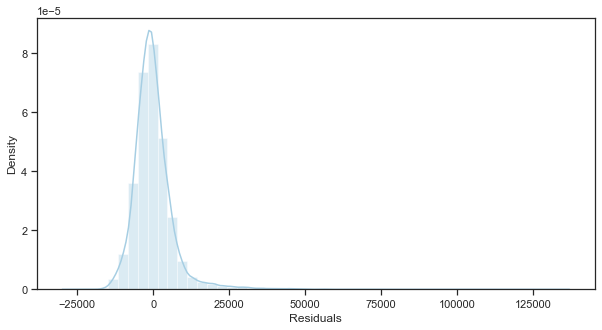

In [110]:
# histogram
plt.figure(figsize=(10,5))
sns.distplot(result.resid)
plt.xlabel('Residuals')
plt.show()


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


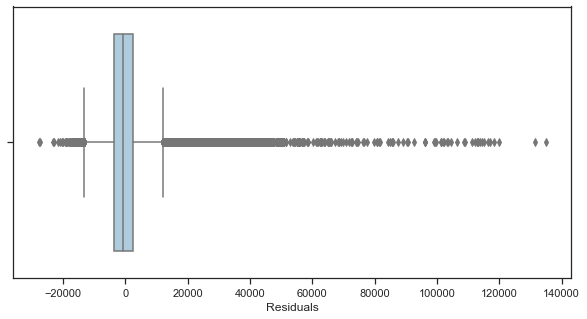

In [111]:
# boxplot
plt.figure(figsize=(10,5))
sns.boxplot(result.resid)
plt.xlabel('Residuals')
plt.show()

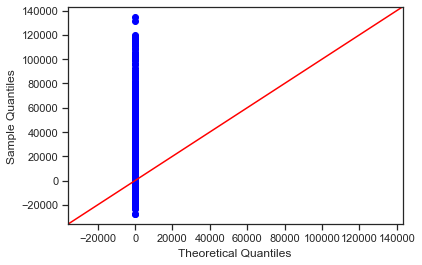

In [112]:
sm.qqplot(result.resid, line='45') #kalau data sangat banyak, disarankan pakai qqplot
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


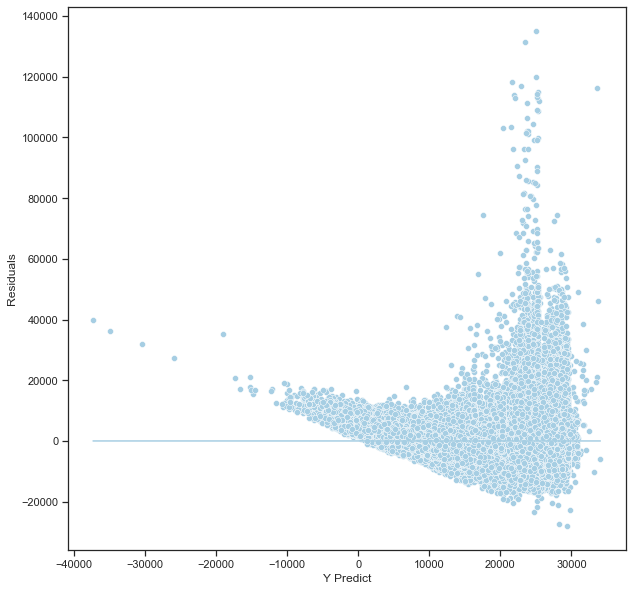

In [113]:
plt.figure(figsize=(10,10))
sns.scatterplot(result.fittedvalues, result.resid)
sns.lineplot(result.fittedvalues,0)
plt.xlabel('Y Predict')
plt.ylabel('Residuals')
plt.show()